# [IAPR][iapr]: Lab 3 ‒  Classification (old)


**Group ID:** 23

**Author 1 (sciper):** Jérémy Baffou (301972)  
**Author 2 (sciper):** Léon Delachaux (296093)   
**Author 3 (sciper):** Martin Dahl (344218)    

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join("../..", 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

We plot the three classes on 2d plane to have an insight of their distribution:

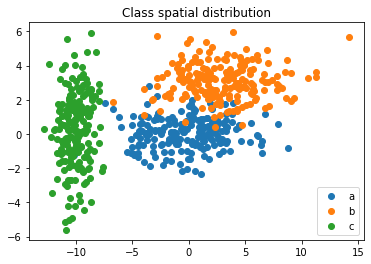

In [3]:
fig, ax = plt.subplots()
ax.set_title("Class spatial distribution")
ax.scatter(a[:,0],a[:,1],label="a")
ax.scatter(b[:,0],b[:,1],label="b")
ax.scatter(c[:,0],c[:,1],label="c")
ax.legend();

We can maybe assume the distributions to be gaussian, but their variance won't be isotropic and not the same for all classes .Indeed, eventhough the spreads of class $a$ and $b$ seem similar, the spread for class $c$ looks like a rotation by $\frac{\pi}{2}$ of the distribution of other classes. This implies that the decision boundaries will be a bit more complicated than just a perpendicular line at equidistance of means.

We now compute the rounded estimators for the mean and variance of each class:

In [4]:
u_a, u_b, u_c = np.concatenate([a[np.newaxis,:,:],b[np.newaxis,:,:],c[np.newaxis,:,:]],axis=0).mean(axis=1).round()
sigma_a, sigma_b, sigma_c = np.cov(a.T).round(), np.cov(b.T).round(), np.cov(c.T).round()
print(f"Rounded mean vector for class a = {u_a}, b = {u_b}, c = {u_c}")
print("Rounded covariance matrix for class \n" +f"a = {sigma_a} \n" +f"b = {sigma_b} \n" +f"c = {sigma_c} \n")

Rounded mean vector for class a = [-0.  0.], b = [3. 3.], c = [-10.   0.]
Rounded covariance matrix for class 
a = [[10.  0.]
 [ 0.  1.]] 
b = [[10.  0.]
 [ 0.  1.]] 
c = [[1. 0.]
 [0. 5.]] 



By looking at the different covariance, it seems to validate the hypothesis that class a and b follows the same (but shifted) distributions. Thus we expect the separation curve to be a straight line. Where as the other curves should be quadrics.

We have the same number of points for each class, thus we assume that we have a uniform prior distributions for the class choice: $P(a)=P(b)=P(c)=\frac{1}{3}$. As the prior are uniform they are simply constant in our decision rule that we can neglect. We define now for class $i$, the discriminant function $g_i(x)$ to be: $g_i(x) = -\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)$

In [5]:
def g_i(x,mean_i,sigma_i):
    """ Discriminant function for class i. """
    return (-1/2)*(x-mean_i).T@np.linalg.inv(sigma_i)@(x-mean_i)

We will now retrieve the separating curves. They are composed by all points with equal values of $g_i(x)$ and $g_j(x)$, where $i,j$ are classes. These are the boundaries where the model cannot make a decision as the given point $x$ is as likely to be part from class $i$ or class $j$. Thus we define a separating curve as : $g_{ij}(x): g_i(x) - g_j(x) = 0$

In [10]:
def g_ij():
    """ Retrieve all the separating curves points in the local subspace of the data. """
    zeros = []
    for x in np.linspace(-12,15,num=300):
        for y in np.linspace(-6,6,num=120):
            point = np.asarray([x,y])
            g_a = g_i(point,u_a,sigma_a)
            g_b = g_i(point,u_b,sigma_b)
            g_c = g_i(point,u_c,sigma_c)
            if np.round(g_a - g_b) == 0:
                zeros.append((point,"a_b"))
            if np.round(g_a - g_c) == 0:
                zeros.append((point,"a_c"))
            if np.round(g_b - g_c) == 0:
                zeros.append((point,"b_c"))
    return zeros

def plot_separating_curves(zeros):
    """ Plot the data with the separating curves. """
    a_b_curve = np.asarray([t[0] for t in zeros if t[1] == "a_b"])
    a_c_curve = np.asarray([t[0] for t in zeros if t[1] == "a_c"])
    b_c_curve = np.asarray([t[0] for t in zeros if t[1] == "b_c"])
    fig, ax = plt.subplots()
    ax.set_title("Separating curves")
    ax.scatter(a[:,0],a[:,1],label="a")
    ax.scatter(b[:,0],b[:,1],label="b")
    ax.scatter(c[:,0],c[:,1],label="c")
    ax.scatter(a_b_curve[:,0],a_b_curve[:,1],label="a_b_curve")
    ax.scatter(a_c_curve[:,0],a_c_curve[:,1],label="a_c_curve")
    ax.scatter(b_c_curve[:,0],b_c_curve[:,1],label="b_c_curve")
    ax.legend();

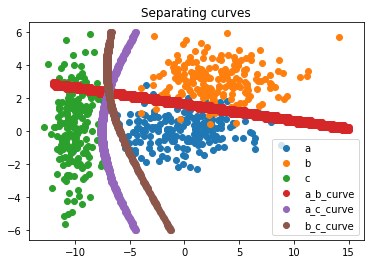

In [11]:
zeros = g_ij()
plot_separating_curves(zeros)

We indeed see a straigth line separating class $a$ and $b$, and quadrics separating $a$ from $c$ and $b$ from $c$. The line are pretty thick due to the fact that we are using scatter plots and that we are taking too much points to interpolate. But it is not a problem for us as the goal is to have an idea of the boundaries rather than to have a precise delimitation. Indeed in practice we would use for example the Mahalanobis distance to classify rather than looking directly at the curve.

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

The Mahalanobis distance of point $x$ to class $i$ is given by: $d_m = \sqrt{(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)}$

In [12]:
def mahalanobis_dist(x,u,sigma):
    return np.sqrt((x-u).T@np.linalg.inv(sigma)@(x-u))

We will now draw a random sample of class $a$ and $b$ of size 10 and compare the decision comming from minimum Mahalanobis distance and from the separating curve.

In [13]:
np.random.seed(100)
random_sample_a = a[np.random.choice(np.arange(a.shape[0]),replace=False,size=10)]
random_sample_b = b[np.random.choice(np.arange(b.shape[0]),replace=False,size=10)]

In [14]:
def plot_random_sample():
    zeros = g_ij()
    a_b_curve = np.asarray([t[0] for t in zeros if t[1] == "a_b"])
    fig, ax = plt.subplots()
    ax.set_title("Random Samples Distribution")
    ax.scatter(random_sample_a[:,0],random_sample_a[:,1],label="a")
    ax.scatter(random_sample_b[:,0],random_sample_b[:,1],label="b")
    ax.plot(a_b_curve[:,0],a_b_curve[:,1],label="a_b_curve")
    ax.legend();

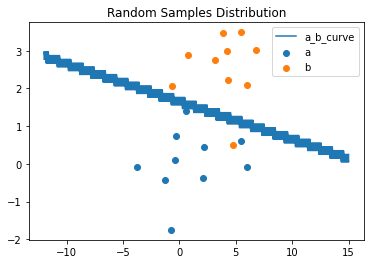

In [15]:
plot_random_sample()

In [16]:
def min_mahanalobis_distance():
    distances_a_to_a = [mahalanobis_dist(x,u_a,sigma_a) for x in list(random_sample_a)]
    distances_a_to_b = [mahalanobis_dist(x,u_b,sigma_b) for x in list(random_sample_a)]
    distances_b_to_a = [mahalanobis_dist(x,u_a,sigma_a) for x in list(random_sample_b)]
    distances_b_to_b = [mahalanobis_dist(x,u_b,sigma_b) for x in list(random_sample_b)]
    distances_a = zip(distances_a_to_a,distances_a_to_b)
    distances_b = zip(distances_b_to_a,distances_b_to_b)
    class_attribution_a = ["a" if t[0] < t[1] else "b" for t in distances_a]
    class_attribution_b = ["a" if t[0] < t[1] else "b" for t in distances_b]
    return class_attribution_a, class_attribution_b

In [17]:
min_mahanalobis_distance()

(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 ['b', 'b', 'b', 'a', 'b', 'b', 'b', 'b', 'b', 'b'])

In [18]:
missclassified_idx = min_mahanalobis_distance()[1].index("a")
print(f"Missclassified point : {random_sample_b[missclassified_idx]}")

Missclassified point : [4.73178817 0.50046656]


We see that using the minimum Mahanalobis rule we also missclassify the same point. Here the Mahalanobis distance is equivalent to the "complete" Bayes classification as we have uniform priors.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [19]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [20]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

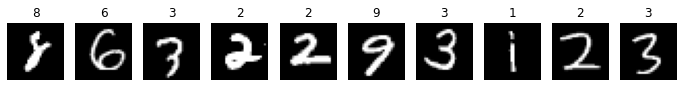

In [21]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

#### Model Creation

To create the MLP we will be using the library TensorFlow. 

In [22]:
# Add your implementation and discussion
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical

We begin by transforming the target variable (here the labels) in a categorical form rather than a numeric one. It will allow us to use losses such as Categorical Cross Entropy to train our deep network. We also flatten the images into arrays of shape $(1,784)$ because the input to a MLP is 1D. We loose some spatial structure but hope that the MLP will be able to retrieve them in the 1D vector.

In [23]:
train_labels_cat = to_categorical(train_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)
train_images_flat = train_images.reshape((train_images.shape[0],28*28))
test_images_flat = test_images.reshape((test_images.shape[0],28*28))

We now create the model. It is composed of an input layer with 784 nodes. Then there are two dense layers of 50 units with Rectified Linear Unit activation function. We prefer ReLU as opposed to a sigmoid because of its ability to have non linearity even with small drive and it is less prone to vanishing gradient. We are unsure if the recommendation of the exercise was 100 hidden units in total or per hidden layer. We kept 100 hidden units in total but we should change the structure if it was not the case (to gain a bit of expressive power). 

Finally we have a layer of sigmoid functions to map to the 10 possible labels. Note that the output vector is not a probability distribution, but rather has as entries the probability that the digit has this label according to the model.

In [24]:
def MLP():
    # Input layer
    im_input = layers.Input(shape=28*28, name="image_input")
    # Hidden Layers
    x = layers.Dense(units=50,activation="relu")(im_input)
    x = layers.Dense(units=50,activation="relu")(x)
    #x = layers.Dense(units=100,activation="relu")(x)
    # Output 
    x = layers.Dense(units=10,activation="sigmoid")(x)
    model = tf.keras.Model(inputs=im_input,outputs=x,name="MLP_MNIST")
    return model

We use the Categorical Cross Entropy as loss function: $CE=-\sum_{i=1}^{10}{y_i\log(\hat y_i)}$, where $y_i$ is 1 if $i$ is the ground truth label and 0 otherwise. And $\hat y_i$ is the label probability prediction of the model.

In [25]:
def classification_loss(labels, output_net):
    cce = tf.keras.losses.CategoricalCrossentropy()
    return cce(labels,output_net)

#### Model Training

We then define the training pipeline. The model is trained using Stochastic Gradient Descent with a learning rate of 0.001. We use a batch version of the algorithm to have a better estimate of the gradient at each step (batch size = 16). We run over 10 epochs. 

In [26]:
@tf.function
def train_step(model,digits,labels,criterion,optimizer):
    """ Make a single training step. """
    num_batch, N = tf.keras.backend.int_shape(digits)  
    # Define Gradient Tape
    with tf.GradientTape() as tape:
        # Get predictions for labels
        output_net = model({'image_input': digits})
        # Compute the loss
        loss = criterion(labels, output_net)
    # Compute gradients.
    grads = tape.gradient(loss, model.trainable_variables)
    # Update the trainable parameters.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def training(train_data,train_label,epochs,batch_size,lr):
    """ Perfom the training of the MLP. """
    # Batch the dataset.
    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    x_train = from_tensor_slices(train_data).batch(batch_size)
    x_label = from_tensor_slices(train_label).batch(batch_size)
    # Create the model
    model = MLP()
    # optimizer set up
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    criterion = classification_loss
    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    for epoch in range(epochs):
        m_train.reset_states()
        for digits, labels in zip(x_train,x_label):
            loss_train = train_step(model, digits, labels, criterion,
                                    optimizer)
            m_train.update_state(loss_train)
        print(f"Epoch: {epoch+1}/{epochs}\tTrain Loss: {m_train.result()}")
    print('\n')
    return model

In [27]:
MLP_MNIST = training(train_images_flat,train_labels_cat,10,16,0.001)

Epoch: 1/10	Train Loss: 1.1834958791732788
Epoch: 2/10	Train Loss: 0.660178005695343
Epoch: 3/10	Train Loss: 0.5091414451599121
Epoch: 4/10	Train Loss: 0.4216517210006714
Epoch: 5/10	Train Loss: 0.3613654375076294
Epoch: 6/10	Train Loss: 0.32132723927497864
Epoch: 7/10	Train Loss: 0.29788967967033386
Epoch: 8/10	Train Loss: 0.2749994397163391
Epoch: 9/10	Train Loss: 0.2599402964115143
Epoch: 10/10	Train Loss: 0.24902397394180298




#### Model Assessment 

We will now evaluate the performance of the model on both the training set and the test set.

In [28]:
MLP_MNIST.compile(tf.keras.optimizers.SGD(),
                  tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
train_results = MLP_MNIST.evaluate(train_images_flat, train_labels_cat, verbose=1)
test_results = MLP_MNIST.evaluate(test_images_flat, test_labels_cat, verbose=1)
print(f'Test results - Loss: {train_results[0]} - Accuracy: {train_results[1]}%')
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

313/313 [==============================] - 3s 9ms/step - loss: 0.3341 - accuracy: 0.9139
Test results - Loss: 0.2737863063812256 - Accuracy: 0.9207500219345093%
Test results - Loss: 0.3340546488761902 - Accuracy: 0.9139000177383423%


Eventhough we have a loss in accuracy between the training and test set, we have still some good results with an accuracy of around 92% on the test set.

To improve the performance using a MLP we could have adjust more carefully the learning rate, normalize the images or choose another optimizer. An interesting metrics that we could have extracted is the class accuracy, which could have given indications of where the model has troubles. We then would have been able to add other features to try to improve the model.